In [1]:
import tensorflow as tf

In [2]:
# input_file = "./../tibert/albert_pretrain/training_data/*.tf_record"
input_file = "c:/workspace/tibert_data/test-data/original-run/*.tf_record"

In [3]:
input_files = []
for input_pattern in input_file.split(","):
    input_files.extend(tf.gfile.Glob(input_pattern))
input_files

['c:\\workspace\\tibert_data\\test-data\\original-run\\train_Kangyur0-maxseq-128.tf_record']

In [4]:
d = tf.data.TFRecordDataset(input_files)

In [5]:
max_seq_length, max_predictions_per_seq, batch_size = 128, 20, 16

In [6]:
name_to_features = {
    "input_ids": tf.FixedLenFeature([max_seq_length], tf.int64),
    "input_mask": tf.FixedLenFeature([max_seq_length], tf.int64),
    "segment_ids": tf.FixedLenFeature([max_seq_length], tf.int64),
    # Note: We keep this feature name `next_sentence_labels` to be
    # compatible with the original data created by lanzhzh@. However, in
    # the ALBERT case it does represent sentence_order_labels.
    "next_sentence_labels": tf.FixedLenFeature([1], tf.int64),
}

# if FLAGS.masked_lm_budget:
#   name_to_features.update({
#       "token_boundary":
#           tf.FixedLenFeature([max_seq_length], tf.int64)})
# else:
name_to_features.update({
  "masked_lm_positions":
      tf.FixedLenFeature([max_predictions_per_seq], tf.int64),
  "masked_lm_ids":
      tf.FixedLenFeature([max_predictions_per_seq], tf.int64),
  "masked_lm_weights":
      tf.FixedLenFeature([max_predictions_per_seq], tf.float32)})

In [7]:
def _decode_record(record, name_to_features):
  """Decodes a record to a TensorFlow example."""
  example = tf.parse_single_example(record, name_to_features)

  # tf.Example only supports tf.int64, but the TPU only supports tf.int32.
  # So cast all int64 to int32.
  for name in list(example.keys()):
    t = example[name]
    if t.dtype == tf.int64:
      t = tf.to_int32(t)
    example[name] = t

  return example

In [8]:
d = d.apply(
    tf.data.experimental.map_and_batch_with_legacy_function(
        lambda record: _decode_record(record, name_to_features),
        batch_size=batch_size,
        num_parallel_batches=4,
        drop_remainder=True))

Instructions for updating:
Use `tf.data.experimental.map_and_batch()

Instructions for updating:
Use `tf.cast` instead.


In [9]:
next_item_iter = d.make_one_shot_iterator().get_next()

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


In [10]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    next_item = sess.run(next_item_iter)

In [11]:
next_item

{'input_ids': array([[   2, 9874, 9955, ...,  951, 2414,    3],
        [   2, 9874, 9923, ...,    0,    0,    0],
        [   2, 9887,   14, ..., 9875, 9955,    3],
        ...,
        [   2, 9874, 9955, ...,    0,    0,    0],
        [   2,  411,    4, ...,  818, 9890,    3],
        [   2,  260,   99, ..., 9875, 9955,    3]]),
 'input_mask': array([[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]]),
 'masked_lm_ids': array([[  51, 9888, 9903, 9955, 9874, 9955,  109,  851, 5353, 9955, 9874,
         9955, 9874, 9955,  175, 4057, 2109,  417,  681,    0],
        [4905,   13, 1317,  590, 1789, 3839, 9881, 9955, 9955, 9881,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0],
        [9909, 9877, 9955, 1019, 9955, 9874, 9955, 9887, 9882,   13,  372,
          156,   57, 9880, 9912, 9887,  100,   31, 9879,    0],
     

In [12]:
next_item['input_ids'].shape

(16, 128)

In [13]:
import tibert.models.training as training

In [14]:
tibert_tkn = training.make_tokenizer(tokenizer_name="tibert-bpe-large")
tibert_tkn.stochastic_tokenization = False

In [15]:
i = 0

In [16]:
print(tibert_tkn.decode(next_item['input_ids'][i]))
i += 1

[CLS] །[MASK][MASK]་པོས་སྤྲོ་ཞིང་བརྟེན་པ་ཡིས།[SEP]དྨའི་གདན། །ཇི་ལ[MASK]ར་སྡེ་ཚན་གསུམ་པ་ཡི། །ཡི་གེ་གསུམ་པ་བཟུང་བྱས་ལ། །གླུ་རུ་རྡོ་རྗེ་དབྱུག་པ་དང་།[MASK]སོང་བ་གཉིས་ུའོག་[MASK]གིས་ནི་དཀྲི[MASK][MASK] བོངས་སྔགས་པ་མཆོག་གི་ས་བོན་འདི།[MASK]།ཀུན་ནས་བཟླ་ཞིང་སྔོན་དུ་གཟུང་། [MASK][MASK][MASK]མས་ ཀུན་ནས་མཉེས་བྱས་ནས། །[MASK][MASK][MASK]ནི་བཟའ་[SEP]


# MLM loss of a trained model

In [17]:
import torch
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm

In [18]:
import tibert.models.training as training

In [19]:
from transformers import AutoConfig, AlbertForMaskedLM

In [20]:
tibert_mdl = AlbertForMaskedLM.from_pretrained(
    'c:/workspace/tibert_data/training/models/tibert-training-test/679000.bin',
    config=AutoConfig.from_pretrained("albert-base-v2"))
# tibert_mdl = AlbertForMaskedLM.from_pretrained(
#     'c:/workspace/tibert_data/training/models/tibert-champion/676000.bin',
#     config=AutoConfig.from_pretrained("albert-base-v2"))
tibert_mdl.resize_token_embeddings(len(tibert_tkn))

- This IS expected if you are initializing AlbertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing AlbertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Embedding(10000, 128)

In [21]:
tibert_mdl = tibert_mdl.cuda().eval()

In [22]:
def prep_batch(next_item):
    input_ids, labels = next_item['input_ids'], np.array([-100 for _ in range(next_item['input_ids'].size)]).reshape(next_item['input_ids'].shape)
    for idx, row in enumerate(input_ids):
        masked_lm_pos = next_item['masked_lm_positions'][idx][:-1]
        labels[idx][masked_lm_pos] = next_item['masked_lm_ids'][idx][:-1]
    return input_ids, labels

In [23]:
def get_ce(input_ids, labels):
    batch = {
        'input_ids': torch.LongTensor(input_ids).to("cuda"),
        'labels': torch.LongTensor(labels).to("cuda")}
    ce, _ = tibert_mdl(**batch)
    return float(ce)

In [24]:
ces = []

In [25]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [26]:
for _ in tqdm(range(100)):
    next_item = sess.run(next_item_iter)
    input_ids, labels = prep_batch(next_item)
    ces.append(get_ce(input_ids, labels))
pd.Series(ces).describe()

count    100.000000
mean       2.248060
std        0.540184
min        1.020124
25%        1.902204
50%        2.154891
75%        2.537830
max        4.064529
dtype: float64

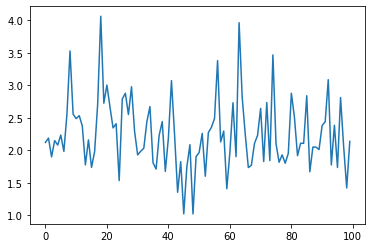

In [27]:
pd.Series(ces).plot()

In [28]:
sess.close()

# Pretraining loss of a trained model

In [29]:
import torch
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm

In [30]:
import tibert.models.training as training

In [31]:
from transformers import AutoConfig, AlbertForPreTraining

In [39]:
tibert_mdl = AlbertForPreTraining.from_pretrained(
    'c:/workspace/tibert_data/training/models/tibert-training-test/679000.bin',
    config=AutoConfig.from_pretrained("albert-base-v2"))
# tibert_mdl = AlbertForPreTraining.from_pretrained(
#     'c:/workspace/tibert_data/training/models/tibert-champion/676000.bin',
#     config=AutoConfig.from_pretrained("albert-base-v2"))
tibert_mdl.resize_token_embeddings(len(tibert_tkn))

Embedding(10000, 128)

In [40]:
tibert_mdl = tibert_mdl.cuda().eval()

In [34]:
def prep_batch(next_item):
    input_ids, labels = next_item['input_ids'], np.array([-100 for _ in range(next_item['input_ids'].size)]).reshape(next_item['input_ids'].shape)
    for idx, row in enumerate(input_ids):
        masked_lm_pos = next_item['masked_lm_positions'][idx][:-1]
        labels[idx][masked_lm_pos] = next_item['masked_lm_ids'][idx][:-1]
    return input_ids, labels

In [35]:
from torch.nn import CrossEntropyLoss

def get_ce(input_ids, labels):
    batch = {
        'input_ids': torch.LongTensor(input_ids).to("cuda"),
        'labels': torch.LongTensor(labels).to("cuda"),
        'sentence_order_label': torch.LongTensor(next_item['next_sentence_labels'].squeeze()).to("cuda"),
        'attention_mask': torch.LongTensor(next_item['input_mask']).to("cuda"),
        'token_type_ids': torch.LongTensor(next_item['segment_ids']).to("cuda")}
    ce, _, sop_logits = tibert_mdl(**batch)
    sentence_order_loss = float(CrossEntropyLoss()(sop_logits.view(-1, 2), batch['sentence_order_label'].view(-1)))
    return float(ce) - sentence_order_loss, sentence_order_loss

In [36]:
mlm_ces, sop_ces = [], []

In [37]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [41]:
for _ in tqdm(range(100)):
    next_item = sess.run(next_item_iter)
    input_ids, labels = prep_batch(next_item)
    mlm_ce, sop_ce = get_ce(input_ids, labels)
    mlm_ces.append(mlm_ce)
    sop_ces.append(sop_ce)
res_df = pd.DataFrame({"mlm": mlm_ces, "sop": sop_ces})
res_df.describe()

,mlm,sop
count,100.000000,100.000000
mean,1.693813,0.881339
std,0.337240,0.066188
min,0.852854,0.710863
25%,1.464299,0.841271
50%,1.664127,0.890124
75%,1.909198,0.936265
max,2.880752,1.010172


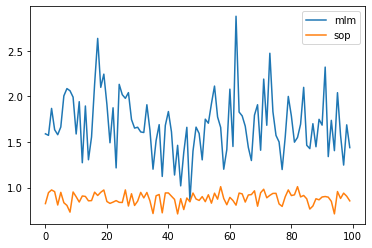

In [42]:
res_df.plot()

In [43]:
sess.close()

# Blank token

In [19]:
tibert_tkn.decode([9874])

''

In [31]:
tibert_tkn.decode([2, 9874, 9955, 4, 4, 9873, 9890, 9877, 9875, 9873, 92, 9891, 15, 626
, 5063, 9902, 9882, 9875, 9955, 3, 9879, 9919, 9887, 9882, 9873, 264, 9886, 9955
, 9874, 9955, 2025, 9888])

'[CLS] །[MASK][MASK]་པོས་སྤྲོ་ཞིང་བརྟེན་པ་ཡིས།[SEP]དྨའི་གདན། །ཇི་ལ'

In [40]:
tibert_tkn.decode([9955, 9874, 9955])

'། །'

In [39]:
tibert_tkn.encode('པོ། །ས')

[2, 257, 9877, 9955, 9874, 9955, 9875, 3]

In [41]:
for batch in next_item['input_ids']:
    if 9874 in batch:
        print(batch)
        break

[   2 9874 9955    4    4 9873 9890 9877 9875 9873   92 9891   15  626
 5063 9902 9882 9875 9955    3 9879 9919 9887 9882 9873  264 9886 9955
 9874 9955 2025 9888    4   13 9875 9908   26  872  149   16 9902 9882
 9955 9874 9955  417  458   76 9881   19 9890 9873  133 9881    9  533
 9888 9955 9874 9955 9876 9906 3160 1291 9879   31  279  251 9955    4
 2274  252 9881  851    4  798 9886 9882 9873  785 9882    4    4 8799
  484  340  488  181    8 1036   75 9882 9955    4 9955 9895   59   89
 5640 9900 9882    9  991 9879   21 1947 9955 9874    4    4    4 9883
 9875 9873 1316 7828  533 9886 9875 9955 9874 9955    4    4    4  951
 2414    3]
